In [48]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import random

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [3]:
LIM=5000
txtfile = 'imdb.pos'  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = 'imdb.neg' # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [4]:
data = postxt + negtxt
label = np.concatenate((np.ones(len(postxt)),np.zeros(len(negtxt))),axis=0)

In [5]:
print(data[10])
print(label[10])

['get', 'in', 'the', 'back', 'of', 'the', 'van', '!']
1.0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1, random_state=1 ,stratify=label)
X_train,X_dev,y_train,y_dev = train_test_split(X_train , y_train , test_size=0.1, random_state = 1 , stratify=y_train)

In [7]:
print(X_train[10])
print(y_train[10])

['laughton', 'enjoyable', 'in', 'this', 'low', 'budget', 'pirate', 'saga']
0.0


# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [8]:
class Dict:
    def __init__(self, words, unk=None):
        self._unk = unk
        self._word_to_id = dict()
        self._id_to_word = list()

        if unk in words:
            raise RuntimeError("UNK word exists in vocabulary")

        if unk is not None:
            self.unk_index = self._add_word(unk)

        for word in words:
            self._add_word(word)

    # for internal use only!
    def _add_word(self, word):
        if word not in self._word_to_id:
            id = len(self._id_to_word)
            self._word_to_id[word] = id
            self._id_to_word.append(word)
            return id
        else:
            return self._word_to_id[word]

    def str_to_id(self, word):
        if self._unk is not None:
            return self._word_to_id.get(word, self.unk_index)
        else:
            return self._word_to_id[word]

    def id_to_str(self, id):
        return self._id_to_word[id]

    def __len__(self):
        return len(self._word_to_id)

    def has_unk(self):
        return self._unk is not None
    
    def unk(self):
        return self.unk_index

In [9]:
#Creating a dict where each word is associated to a number
token_index = {}
for sent in X_train:
    for word in sent:
        if word not in token_index:
            token_index[word] = len(token_index) + 1
#Don't forget to add the unk = True because some words maybe in the dev or test but not in the train
token_index = Dict(token_index, unk=True)


In [10]:
print(len(token_index))

7032


# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddingsÂ (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [54]:

class Conv_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, size, feat_size, pool_type):
        super(Conv_classifier, self).__init__()
        
        #Embedding layer
        self.emb_db = nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        #Conv layers
        self.convs = nn.Linear(size*embedding_dim,feat_size)
        #Last layer
        self.l1 = nn.Linear(feat_size, 1)
        
        #Various parameters you need
        self.size = size
        self.pool_type = pool_type
        #inits
        nn.init.xavier_uniform_(self.l1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.l1.bias.data)  # Xavier/Glorot init for tanh
        
    def forward(self, inputs ):
        idx = 0
        size = self.size
        if(inputs.shape[0]<size):
            pad = torch.tensor([0 for i in range(size-inputs.shape[0])])
            inputs = torch.cat((inputs, pad), 0)

        inputs = self.emb_db(inputs)
        cat_inputs= []
        h = torch.Tensor(inputs.shape[0], inputs.shape[1]*size)

        for i in range(len(inputs)-size+1):
            tab = [inputs[j] for j in range(i, size+i)]
            cat = torch.cat(tab, 0)
            cat_inputs.append(self.convs(cat))

        h = torch.stack(cat_inputs)

        if (self.pool_type == "max"):
#             #MAX
            h, _ = torch.max(h, 0)
        if (self.pool_type == "mean"):
        #MEAN
            h = torch.mean(h,0)
        out = self.l1(h)
        return torch.sigmoid(out)

In [44]:
class Conv_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_size, feat_size):
        super(Conv_classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.conv1 = nn.Linear(embedding_dim*kernel_size, feat_size)
        self.l1 = nn.Linear(feat_size, 1)
        
        self.kernel_size = kernel_size
        nn.init.xavier_uniform_(self.l1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.l1.bias.data)  # Xavier/Glorot init for tanh
        
    def forward(self, inputs):
        if(inputs.shape[0]<self.kernel_size):
            pad = th.tensor([0 for i in range(self.kernel_size-inputs.shape[0])])
            inputs = th.cat((inputs, pad), 0)
        
        inputs = self.embedding(inputs)
        cat_inputs= []
        h = th.Tensor(inputs.shape[0], inputs.shape[1]*self.kernel_size)
        
        for i in range(len(inputs)-self.kernel_size+1):
            tab = [inputs[j] for j in range(i, self.kernel_size+i)]
            cat = th.cat(tab, 0)
            cat_inputs.append(self.conv1(cat))
        
        h = th.stack(cat_inputs)
        h, _ = th.max(h, 0)
        
        out = self.l1(h)
        return th.sigmoid(out)

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [55]:
loss = torch.nn.BCELoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [79]:
def train(model , epochs, lr ,X_train ,y_train , X_dev , y_dev ,save_path, optimizer ="SGD"):
    
    #defining various types of optimizer
    if (optimizer=="SGD"):
        optimizer = torch.optim.SGD(params=model.parameters(), lr =lr, weight_decay=1e-4)   
    if (optimizer== "AdaDelta"):
        optimizer = torch.optim.Adadelta(params=model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
        
        
    #variables to see the progression
    mean_loss_train = []
    mean_loss_dev = []
    acc_train = []
    acc_dev = []
    
    
    #passe le modele en mode training
    model.train()
    
    for i in range(epochs):
        
        #adaptive learning rate
        if((i+1)%5 == 0):
            for g in optimizer.param_groups:
                g['lr'] = g['lr']*0.8
                
                
        #defining parameters to print the evolution of the NN
        accuracy = 0
        mean_loss = 0
        
        # shuffle to reduce overfitting
        c = list(zip(X_train, y_train))
        random.shuffle(c)
        X_train, y_train = zip(*c)
        
        for sent,label in zip(X_train , y_train):

            # zero the parameter gradients
            optimizer.zero_grad()
            
            #creating the tensors for inputs
            data = torch.LongTensor([token_index.str_to_id(word) for word in sent])

            label = torch.Tensor([label])   
            #prediction and loss
            pred = model(data)
           # print(pred)
            output = loss(pred , label)
            mean_loss+=output.item()
            
            #backward and updates
            output.backward()
            optimizer.step()

            #computing accuracy
            if (pred >= 0.5 and label==1):
                accuracy += 1
            if(pred<0.5 and label==0):
                accuracy += 1
            
        mean_loss_train.append(mean_loss/len(X_train))
        acc_train.append(accuracy/len(X_train))
        print("EPOCHS" , str(i+1) ,"On training : Mean Loss :" , mean_loss/len(X_train) , "Accuracy :" ,accuracy/len(X_train))

        
        mean_loss = 0
        accuracy = 0
        
        ###testing on dev data#########
        for sent,label in zip(X_dev,y_dev):
            data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
            label = torch.Tensor([label])
            
            #prediction and loss
            pred = model(data)
            output = loss(pred , label)
            
            mean_loss+=output.item()
            
            
            #computing accuracy
            if (pred >= 0.5 and label==1):
                accuracy += 1
            if(pred<0.5 and label==0):
                accuracy += 1
            
        print("EPOCH" , str(i+1) ,"On Dev  :Mean Loss :" , mean_loss/len(X_dev) , "Accuracy :" ,accuracy/len(X_dev))
        print()

        mean_loss_dev.append(mean_loss/len(X_dev))
        acc_dev.append(accuracy/len(X_dev))
          
        if (i==0):
            torch.save(model.state_dict(), save_path)
        elif(acc_dev[i] > acc_dev[i-1]):
            torch.save(model.state_dict(),save_path)

            
            
    #Plotting loss accuracy for  test and train
    plt.plot(acc_train , label='Train')
    plt.plot(acc_dev, label="Dev")
    plt.title("Accuracy")
    plt.legend()
    plt.figure()
    
    plt.plot(mean_loss_train , label='Train')
    plt.plot(mean_loss_dev, label="Dev")
    plt.title("Loss")
    plt.legend()
    plt.figure()


In [83]:
def evaluation_test(model, X_test, y_test):
    ##test on test data with the two different models
    mean_loss = 0
    accuracy = 0

    ###testing on dev data#########
    for sent,label in zip(X_test,y_test):
        data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
        label = torch.Tensor([label])

        #prediction and loss
        pred = model(data)
        output = loss(pred , label)
        mean_loss+=output.item()


        #computing accuracy
        if (pred >= 0.5 and label==1):
            accuracy += 1
        if(pred<0.5 and label==0):
            accuracy += 1

    print("Accuracy on test set for this model is" , accuracy/len(X_test))


EPOCHS 1 On training : Mean Loss : 0.7146975976890988 Accuracy : 0.5061728395061729
EPOCH 1 On Dev  :Mean Loss : 0.7259496517148283 Accuracy : 0.5044444444444445

EPOCHS 2 On training : Mean Loss : 0.708738241839556 Accuracy : 0.5116049382716049
EPOCH 2 On Dev  :Mean Loss : 0.715120103839371 Accuracy : 0.5288888888888889

EPOCHS 3 On training : Mean Loss : 0.6903941818394549 Accuracy : 0.5676543209876543
EPOCH 3 On Dev  :Mean Loss : 0.7001525820626153 Accuracy : 0.5255555555555556

EPOCHS 4 On training : Mean Loss : 0.6261411084926451 Accuracy : 0.6565432098765432
EPOCH 4 On Dev  :Mean Loss : 0.5846530627681771 Accuracy : 0.6822222222222222

EPOCHS 5 On training : Mean Loss : 0.5508772208535377 Accuracy : 0.7085185185185185
EPOCH 5 On Dev  :Mean Loss : 0.5323341547164859 Accuracy : 0.7066666666666667

EPOCHS 6 On training : Mean Loss : 0.5068619182353019 Accuracy : 0.7458024691358025
EPOCH 6 On Dev  :Mean Loss : 0.5596383307148224 Accuracy : 0.7088888888888889

EPOCHS 7 On training : M

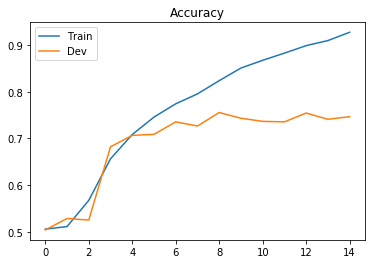

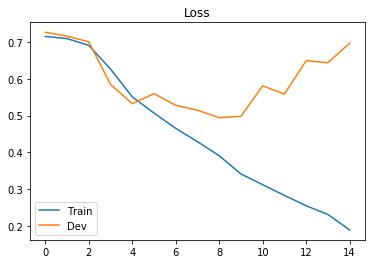

<Figure size 432x288 with 0 Axes>

In [85]:
m = Conv_classifier(len(token_index), 5, 3, 5, pool_type="max" ) 
train(m , 15 , lr=1e-1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev,save_path="model_max_3")


In [86]:
m =  Conv_classifier(len(token_index), 5, 3, 5, pool_type="max" ) 
m.load_state_dict(torch.load("model_max_3"))

evaluation_test(m, X_test, y_test)

Accuracy on test set for this model is 0.745


EPOCHS 1 On training : Mean Loss : 0.6995164051357611 Accuracy : 0.5235802469135803
EPOCH 1 On Dev  :Mean Loss : 0.6746561042467754 Accuracy : 0.5722222222222222

EPOCHS 2 On training : Mean Loss : 0.6653206009590347 Accuracy : 0.5995061728395061
EPOCH 2 On Dev  :Mean Loss : 0.620297408791052 Accuracy : 0.6466666666666666

EPOCHS 3 On training : Mean Loss : 0.5995996331080091 Accuracy : 0.6793827160493827
EPOCH 3 On Dev  :Mean Loss : 0.6073516634913783 Accuracy : 0.6722222222222223

EPOCHS 4 On training : Mean Loss : 0.544971493233482 Accuracy : 0.7232098765432099
EPOCH 4 On Dev  :Mean Loss : 0.5242417915239154 Accuracy : 0.7111111111111111

EPOCHS 5 On training : Mean Loss : 0.4938011023003147 Accuracy : 0.755432098765432
EPOCH 5 On Dev  :Mean Loss : 0.5175329336337745 Accuracy : 0.7244444444444444

EPOCHS 6 On training : Mean Loss : 0.4626900300131653 Accuracy : 0.7777777777777778
EPOCH 6 On Dev  :Mean Loss : 0.5076906684910257 Accuracy : 0.7322222222222222

EPOCHS 7 On training : Me

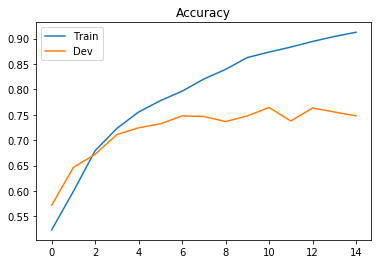

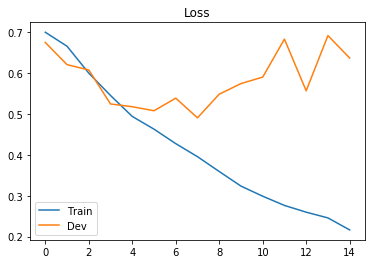

<Figure size 432x288 with 0 Axes>

In [88]:
m = Conv_classifier(len(token_index), 5, 3, 5, pool_type="mean")
train(m , 15 , lr=0.1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev,save_path="model_mean_3")

In [90]:
m =  Conv_classifier(len(token_index), 5, 3, 5, pool_type="mean" ) 
m.load_state_dict(torch.load("model_mean_3"))

evaluation_test(m, X_test, y_test)

Accuracy on test set for this model is 0.74


EPOCHS 1 On training : Mean Loss : 0.6982233288391482 Accuracy : 0.5479012345679012
EPOCH 1 On Dev  :Mean Loss : 0.7318517704556385 Accuracy : 0.5577777777777778

EPOCHS 2 On training : Mean Loss : 0.6616089675418154 Accuracy : 0.6146913580246913
EPOCH 2 On Dev  :Mean Loss : 0.7189128031540248 Accuracy : 0.5433333333333333

EPOCHS 3 On training : Mean Loss : 0.603848855184665 Accuracy : 0.6641975308641975
EPOCH 3 On Dev  :Mean Loss : 0.5865788137245302 Accuracy : 0.6877777777777778

EPOCHS 4 On training : Mean Loss : 0.5480646588483336 Accuracy : 0.7134567901234568
EPOCH 4 On Dev  :Mean Loss : 0.574391494641572 Accuracy : 0.6855555555555556

EPOCHS 5 On training : Mean Loss : 0.4891282769598581 Accuracy : 0.7548148148148148
EPOCH 5 On Dev  :Mean Loss : 0.5317327591292673 Accuracy : 0.7144444444444444

EPOCHS 6 On training : Mean Loss : 0.4487554063976292 Accuracy : 0.7825925925925926
EPOCH 6 On Dev  :Mean Loss : 0.5230053742902561 Accuracy : 0.7088888888888889

EPOCHS 7 On training : M

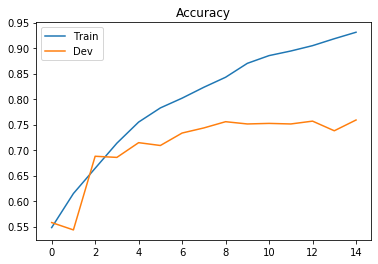

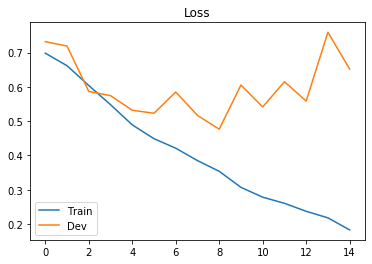

<Figure size 432x288 with 0 Axes>

In [91]:
m = Conv_classifier(len(token_index), 5, 2, 5, pool_type="max" ) 
train(m , 15 , lr=1e-1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev,save_path="model_max_2")


In [94]:
m =  Conv_classifier(len(token_index), 5, 2, 5, pool_type="max" ) 
m.load_state_dict(torch.load("model_max_2"))

evaluation_test(m, X_test, y_test)

Accuracy on test set for this model is 0.757


EPOCHS 1 On training : Mean Loss : 0.6855484071479576 Accuracy : 0.5580246913580247
EPOCH 1 On Dev  :Mean Loss : 0.6739351791143418 Accuracy : 0.6055555555555555

EPOCHS 2 On training : Mean Loss : 0.6277226580208908 Accuracy : 0.6453086419753087
EPOCH 2 On Dev  :Mean Loss : 0.590092359373553 Accuracy : 0.7055555555555556

EPOCHS 3 On training : Mean Loss : 0.5664552596709874 Accuracy : 0.7125925925925926
EPOCH 3 On Dev  :Mean Loss : 0.5384496860260455 Accuracy : 0.71

EPOCHS 4 On training : Mean Loss : 0.5161910379876066 Accuracy : 0.738641975308642
EPOCH 4 On Dev  :Mean Loss : 0.5155656128457162 Accuracy : 0.7311111111111112

EPOCHS 5 On training : Mean Loss : 0.4658679725457173 Accuracy : 0.7762962962962963
EPOCH 5 On Dev  :Mean Loss : 0.505662699490627 Accuracy : 0.7477777777777778

EPOCHS 6 On training : Mean Loss : 0.4338970508013475 Accuracy : 0.794320987654321
EPOCH 6 On Dev  :Mean Loss : 0.48111409291643364 Accuracy : 0.7533333333333333

EPOCHS 7 On training : Mean Loss : 0.40

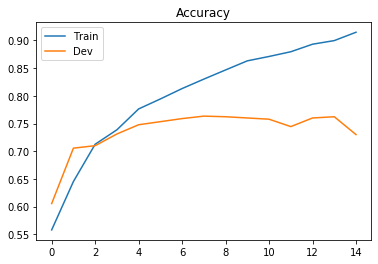

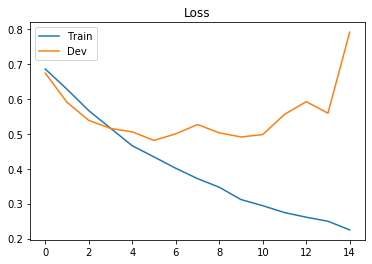

<Figure size 432x288 with 0 Axes>

In [96]:
m = Conv_classifier(len(token_index), 5, 2, 5, pool_type="mean" ) 
train(m , 15 , lr=1e-1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev,save_path="model_mean_2")


In [97]:
m =  Conv_classifier(len(token_index), 5, 2, 5, pool_type="mean" ) 
m.load_state_dict(torch.load("model_mean_2"))

evaluation_test(m, X_test, y_test)

Accuracy on test set for this model is 0.756


# PRE TRAINED EMBEDDING LAYER 

In [98]:
import bcolz
import pickle

In the following cell we load the files containing the pre-trained embeddings (from glove data set), and we save them with pickle for futur uses.

In [99]:
words = []
idx = 0
word2idx = {}
glove_path = '.'
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.50_idx.pkl', 'wb'))

In [100]:
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [101]:
glove['my']

array([-0.27279  ,  0.77515  , -0.10181  , -0.9166   ,  0.90477  ,
       -0.070501 , -0.47569  ,  0.44608  ,  0.1697   ,  0.072352 ,
       -0.16306  ,  0.86852  , -0.76634  , -0.016103 ,  0.78492  ,
        0.2952   , -0.74859  ,  0.2099   ,  0.65537  , -0.62334  ,
       -0.43711  ,  1.1854   ,  0.47519  ,  0.0093866,  1.1377   ,
       -2.4394   , -1.5619   ,  0.49001  ,  1.0985   , -0.97371  ,
        3.4628   ,  1.0408   , -0.65138  ,  0.57189  , -0.12523  ,
        0.26705  ,  0.16373  ,  0.41105  ,  0.7509   , -0.77923  ,
        0.03638  , -0.28609  , -0.72365  ,  0.63511  ,  0.089441 ,
       -0.30133  ,  0.36518  , -0.73367  ,  0.040383 ,  0.26657  ])

In [102]:
pre_trained =[item for sublist in X_train for item in sublist]

In [103]:
matrix_len = len(token_index)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i in range (len(token_index)):
    try: 
        weights_matrix[i] = glove[token_index.id_to_str(i)]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

In [104]:
weights_matrix.shape

(7032, 50)

In [105]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim


In [113]:

class Conv_classifier_pretrained(nn.Module):
    def __init__(self, vocab_size, weights_matrix, size, feat_size , pool_type):
        super(Conv_classifier_pretrained, self).__init__()
        
        #Embedding layer
        self.emb_db, _, embedding_dim = create_emb_layer(torch.tensor(weights_matrix), False)
        #Conv layers
        self.convs = torch.nn.Linear(size*embedding_dim,feat_size)
        #Last layer
        self.l1 = nn.Linear(feat_size, 1)
        
        #Various parameters you need
        self.size = size
        self.pool_type = pool_type
        #inits
        nn.init.xavier_uniform_(self.l1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.l1.bias.data)  # Xavier/Glorot init for tanh
        
    def forward(self, inputs):
        idx = 0
        size =self.size
        if(inputs.shape[0]<size):
            pad = torch.tensor([0 for i in range(size-inputs.shape[0])])
            inputs = torch.cat((inputs, pad), 0)

        inputs = self.emb_db(torch.tensor(inputs))
        cat_inputs= []
        h = torch.Tensor(inputs.shape[0], inputs.shape[1]*size)

        for i in range(len(inputs)-size+1):
            tab = [inputs[j] for j in range(i, size+i)]
            cat = torch.cat(tab, 0)
            cat_inputs.append(self.convs(cat))

        h = torch.stack(cat_inputs)

        if (self.pool_type == "max"):
#             #MAX
            h, _ = torch.max(h, 0)
        if (self.pool_type == "mean"):
        #MEAN
            h = torch.mean(h,0)
        out = self.l1(h)
        return torch.sigmoid(out)

In [114]:
loss = torch.nn.BCELoss()

C:\Users\berte\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


EPOCHS 1 On training : Mean Loss : 0.755749582431373 Accuracy : 0.6511111111111111
EPOCH 1 On Dev  :Mean Loss : 0.8155992213020448 Accuracy : 0.73

EPOCHS 2 On training : Mean Loss : 0.7087169041651677 Accuracy : 0.7044444444444444
EPOCH 2 On Dev  :Mean Loss : 0.7724878474377839 Accuracy : 0.7311111111111112

EPOCHS 3 On training : Mean Loss : 0.5827471796254288 Accuracy : 0.755679012345679
EPOCH 3 On Dev  :Mean Loss : 0.6466015052626615 Accuracy : 0.7366666666666667

EPOCHS 4 On training : Mean Loss : 0.48942805700902126 Accuracy : 0.7966666666666666
EPOCH 4 On Dev  :Mean Loss : 0.5322797189647144 Accuracy : 0.7533333333333333

EPOCHS 5 On training : Mean Loss : 0.365374827818102 Accuracy : 0.8448148148148148
EPOCH 5 On Dev  :Mean Loss : 0.5023346134886176 Accuracy : 0.7444444444444445

EPOCHS 6 On training : Mean Loss : 0.3139771175039111 Accuracy : 0.8688888888888889
EPOCH 6 On Dev  :Mean Loss : 0.48671209123262815 Accuracy : 0.7611111111111111

EPOCHS 7 On training : Mean Loss : 0.

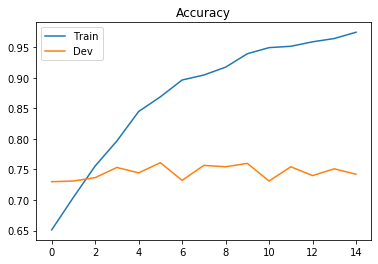

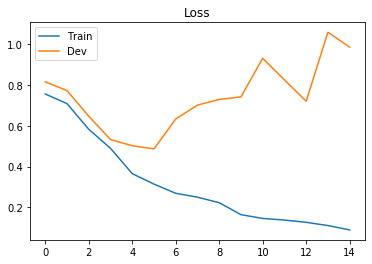

<Figure size 432x288 with 0 Axes>

In [115]:
m2 = Conv_classifier_pretrained(len(token_index), weights_matrix, 3, 5, pool_type="max")
train(m2 , 15 , lr=0.1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev, save_path="pretrained_3_max")


In [119]:
m2 = Conv_classifier_pretrained(len(token_index), weights_matrix, 3, 5, pool_type="max")
m2.load_state_dict(torch.load("pretrained_3_max"))

evaluation_test(m2, X_test, y_test)

C:\Users\berte\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy on test set for this model is 0.778
